In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss
import itertools
import statsmodels.api as sm
import statsmodels.tsa.arima_model as arima

C:\Users\Shruti\AppData\Local\Programs\Python\Python37-32\lib\site-packages\statsmodels\compat\pandas.py:23: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


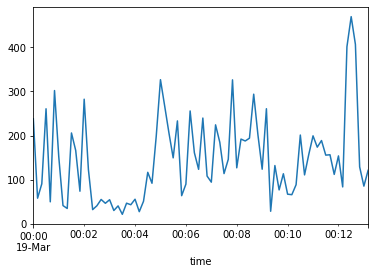

In [2]:
########################### load training data #################
train = pd.read_csv("C:/Users/Shruti/Downloads/train_csv.csv")
#timestamp index
train.index = pd.to_datetime(train.time)
########################### View nature of data ###############
train.feature.plot()

In [3]:
################### Test of stationarity ############
#a) DF Test - Alt Hyp = DIFFERENCE stationary
test1 = adfuller(train.feature)
print("test statistics: ", test1[0])
print("p-value: ", test1[1])
print("lags: ", test1[2])
print("critical values: ", test1[4])

#p value >> critical values
#Null hypothesis is accepted = Series is NOT DIFFERENCE/LINEAR stationary

test statistics:  -5.945866499650217
p-value:  2.205049473411678e-07
lags:  0
critical values:  {'1%': -3.5159766913976376, '5%': -2.898885703483903, '10%': -2.5866935058484217}


In [4]:
#b) KPSS Test - Null Hyp = TREND stationary
test1 = kpss(train.feature)
print("test statistics: ", test1[0])
print("p-value: ", test1[1])
print("lags: ", test1[2])
print("critical values: ", test1[3])

# p value << critical values
#Null hypothesis is rejected = Series is NOT TREND stationary

test statistics:  0.28267735055788507
p-value:  0.1
lags:  12
critical values:  {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


C:\Users\Shruti\AppData\Local\Programs\Python\Python37-32\lib\site-packages\statsmodels\tsa\stattools.py:1709: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


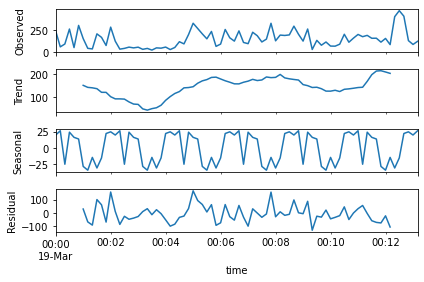

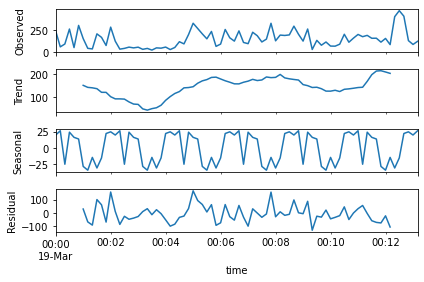

In [7]:
############################## Decompose and see components ################
decom = seasonal_decompose(train.feature, freq =  13)
decom.plot()

In [9]:
########################## difference to make data trend stationary ############
#train_diff = train.feature.diff(periods =  1).dropna()
#plt.plot(train_diff)

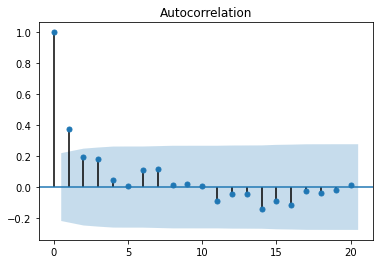

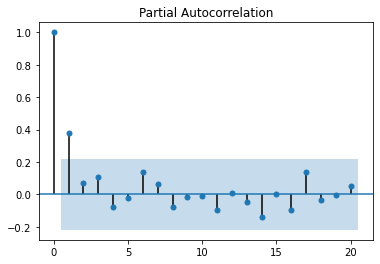

In [10]:
########################## ACF & PACF plot to find periods #############
#only good for stationary data but still..

plot_acf(train.feature)  #MA component
plt.show()    # 1 lag

plot_pacf(train.feature)  #AR component period
plt.show()    # 1 lag 

In [96]:
################################# ARIMA BASE model ##############################
import warnings
warnings.filterwarnings("ignore")
########################################
p = I= q = range(0, 2)
pIq = [x for x in itertools.product(p, I, q)]

res = []
for x in pIq:
    model = arima.ARIMA(train_diff, x).fit(disp=False)
    m = [x, model.aic]   #put model parameters and its aic into a list
    res.append(m)

res_df = pd.DataFrame(res, columns = ['order', 'aic'])

res_df[res_df['aic'] == min(res_df.aic)]  #display parameters for min AIC


,order,aic
5,"(1, 0, 1)",943.839479


In [12]:
model = arima.ARIMA(train.feature, (1,0, 1)).fit(disp=False)

C:\Users\Shruti\AppData\Local\Programs\Python\Python37-32\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency 10S will be used.
  % freq, ValueWarning)


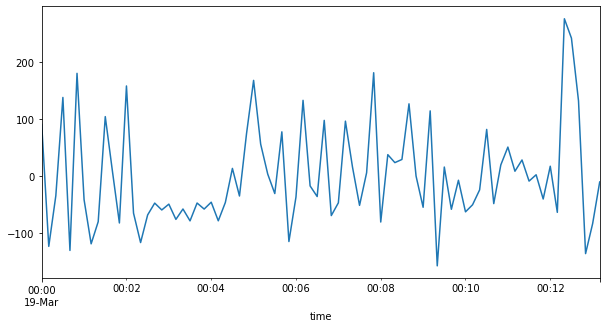

In [13]:
################################# Residual plot of the model ######################
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
ax = model.resid.plot(ax=ax); #residuals should not have patterns with time
#here residuals look just like the training data- that means no info was captured by the ARIMA model

In [14]:
###################### Load Test data ###############
test = pd.read_csv("C:/Users/Shruti/Downloads/test_csv.csv")
test.index = pd.to_datetime(test['time'])

In [15]:
######################## Prediction using model #############
pred = model.predict(start= test.index[0], end = test.index[-1], dynamic= False)

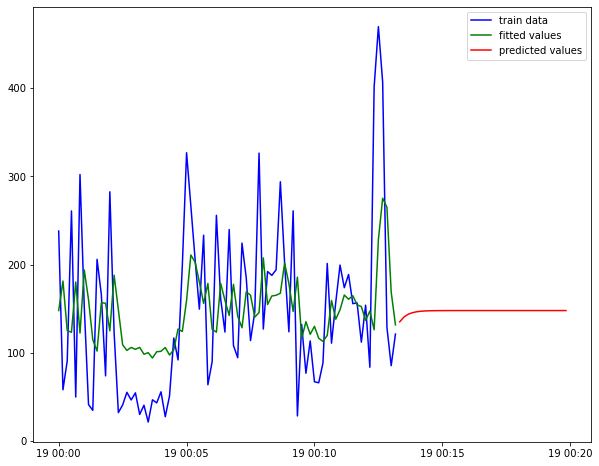

In [16]:
############################ plot the predictions and past values for ARIMA ###############################
plt.figure(figsize=(10, 8))
plt.plot(train['feature'], color='blue', label="train data")     #original train data
plt.plot(model.fittedvalues, color='green', label="fitted values") #fitted values
plt.plot(pred, color='red', label="predicted values")                   #predicted values
plt.legend()
plt.show()  
#Doesn't capture any information- very poor on Train data & train_diff data

##########################################################################################################################

In [138]:
##################################### REMODEL #################################

####################### choose BEST SARIMA parameter for model #############
p = q = d = range(0, 2)
pdq = [x for x in itertools.product(p, d, q)]

seasonal_pdq = [(x[0], x[1], x[2], 13) for x in pdq]
seasonal_pdq   #SEASONAL: AR, diff, MA, M= freq of 1 seasonal period

res = []
for x in pdq:
    for x_seasonal in seasonal_pdq:
        model = sm.tsa.statespace.SARIMAX(train.feature,
                                        order=x,
                                        seasonal_order=x_seasonal,
                                        enforce_stationarity=False,
                                        enforce_invertibility=False)
        model = model.fit()
        m = [x, x_seasonal, model.aic]   #put model parameters and its aic into a list
        res.append(m)

res_df = pd.DataFrame(res, columns = ['order', 'seasonal_order', 'aic'])

res_df[res_df['aic'] == min(res_df.aic)]  #display parameters for min AIC

,order,seasonal_order,aic
59,"(1, 1, 1)","(0, 1, 1, 13)",631.028659


In [140]:
############# SARIMA to model seasonality + trend after parameter choosing ###########
mod = sm.tsa.statespace.SARIMAX(train.feature,
                                order=(1, 1, 1),
                                seasonal_order=(0,1, 1, 13),
                                enforce_stationarity=True,
                                enforce_invertibility=False)
results = mod.fit()


In [147]:
######################## Prediction usig model #############
pred = results.predict(start= test.index[0], end = test.index[-1], dynamic= False)

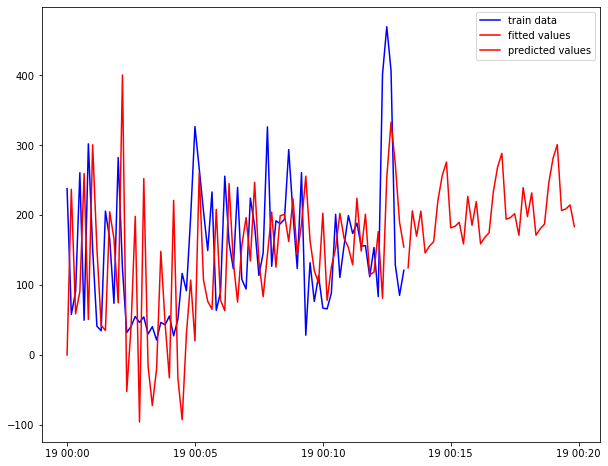

In [149]:
############################ plot the predictions and past values ###############################
plt.figure(figsize=(10, 8))
plt.plot(train['feature'], color='blue', label="train data")     #original train data
plt.plot(results.fittedvalues, color='red', label="fitted values") #fitted values
plt.plot(pred, color='red', label="predicted values")                   #predicted values
plt.legend()
plt.show()

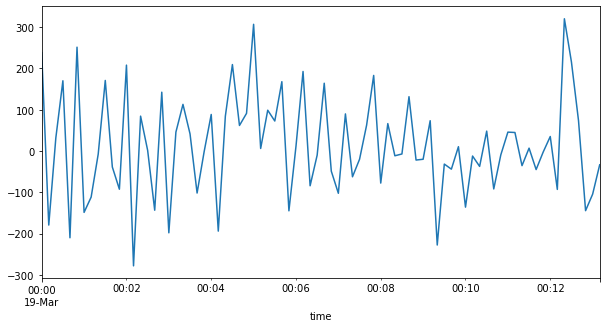

In [130]:
################################# Residual plot of the model ######################
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
ax = results.resid.plot(ax=ax); #residuals should not have patterns with time
#A little trend is noticeable with seasonality - not all info was captured by the model

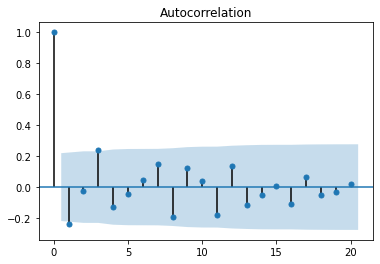

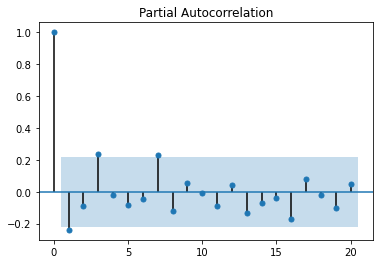

In [131]:
############ See Model Residual Autocorrelation #######

residuals = [x for x in results.resid]
residual_df = pd.DataFrame(residuals)

plot_acf(residual_df)
plt.show() 

plot_pacf(residual_df)
plt.show() 

#residuals should not be correlated

(array([ 2.,  4.,  9.,  9., 21., 13.,  8.,  7.,  5.,  2.]),
 array([-277.91946053, -218.10973538, -158.30001022,  -98.49028507,
         -38.68055991,   21.12916524,   80.9388904 ,  140.74861555,
         200.55834071,  260.36806586,  320.17779102]),
 <a list of 10 Patch objects>)

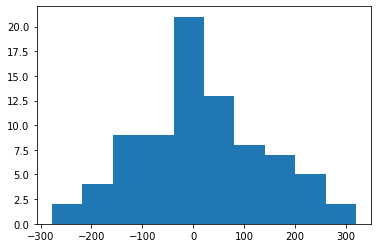

In [132]:
#see distribution of residuals for bias (should be around mean zero)
plt.hist(residuals)
#not bad - pretty normal distribution


In [118]:
##### save into csv for submission ####
pred_df = pd.DataFrame(test.id, columns=['id'])

pred_df['feature'] = pred.values

pred_df.to_csv('terra_timeseries_sarimax_13.csv') #110.96 score
#######################################################################